In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn import tree
from matplotlib import pyplot as plt
import graphviz
from sklearn.metrics import median_absolute_error, mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import PartialDependenceDisplay
from imblearn.under_sampling import RandomUnderSampler

plt.rcParams.update({'figure.figsize': (12.0, 8.0)})
plt.rcParams.update({'font.size': 14})

pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv('final-preprocessed-imputed-compas-df.csv')
print(df.shape)
df.head()

(8280, 43)


,sex,age,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_charge_degree,is_recid,r_charge_degree,r_days_from_arrest,r_offense_date,r_jail_in,is_violent_recid,vr_charge_degree,vr_offense_date,score_text,screening_date,v_decile_score,v_score_text,event,income,jail_duration,Agency_Text,LastName,FirstName,DateOfBirth,LegalStatus,CustodyStatus,MaritalStatus,RecSupervisionLevel,RecSupervisionLevelText,RiskOfViolence_RawScore,RiskOfViolence_DecileScore,RiskOfViolence_ScoreText,RiskOfRecidivism_RawScore,RiskOfRecidivism_DecileScore,RiskOfRecidivism_ScoreText,RiskOfFailureToAppear_RawScore,RiskOfFailureToAppear_DecileScore,RiskOfFailureToAppear_ScoreText
0,Male,34.0,African-American,0.0,3.0,0.0,0.0,0.0,-1.0,10.0,1.0,10.0,0.0,2013-07-05 00:00:00,Unknown,1.0,10.0,2013-07-05 00:00:00,Low,2013-01-27,1.0,Low,1.0,Lower,10.0,PRETRIAL,dixon,kevon,1982-01-22,Pretrial,Jail Inmate,Single,1.0,Low,-3.07,1.0,Low,-0.76,3.0,Low,25.0,6.0,Medium
1,Male,24.0,African-American,0.0,4.0,0.0,1.0,4.0,-1.0,10.0,1.0,1.0,0.0,2013-06-16 00:00:00,2013-06-16 00:00:00,0.0,6.0,Unknown,Low,2013-04-14,3.0,Low,0.0,Lower,1.0,Probation,philo,ed,1991-05-14,Post Sentence,Probation,Single,3.0,Medium with Override Consideration,-1.27,7.0,Medium,0.49,9.0,High,28.0,8.0,High
2,Male,23.0,African-American,0.0,8.0,1.0,0.0,1.0,-1.0,10.0,0.0,2.0,0.0,Unknown,Unknown,0.0,6.0,Unknown,High,2013-01-13,6.0,Medium,0.0,Lower,1.0,PRETRIAL,brown,marcu,1993-01-21,Pretrial,Jail Inmate,Single,3.0,Medium with Override Consideration,-1.59,6.0,Medium,0.16,8.0,High,19.0,3.0,Low
3,Male,43.0,Other,0.0,1.0,0.0,0.0,2.0,-1.0,16.0,0.0,2.0,0.0,Unknown,Unknown,0.0,6.0,Unknown,Low,2013-03-26,1.0,Low,0.0,Lower,1.0,PRETRIAL,pierrelouis,bouthy,1973-01-22,Pretrial,Pretrial Defendant,Married,1.0,Low,-3.23,1.0,Low,-2.20,1.0,Low,12.0,1.0,Low
4,Male,44.0,Other,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,Unknown,Unknown,0.0,6.0,Unknown,Low,2013-11-30,1.0,Low,0.0,Lower,1.0,PRETRIAL,miles,marsha,1971-08-22,Pretrial,Jail Inmate,Separated,1.0,Low,-3.30,1.0,Low,-1.93,1.0,Low,19.0,3.0,Low


In [4]:
df.columns

Index(['sex', 'age', 'race', 'juv_fel_count', 'decile_score', 'juv_misd_count',
       'juv_other_count', 'priors_count', 'days_b_screening_arrest',
       'c_charge_degree', 'is_recid', 'r_charge_degree', 'r_days_from_arrest',
       'r_offense_date', 'r_jail_in', 'is_violent_recid', 'vr_charge_degree',
       'vr_offense_date', 'score_text', 'screening_date', 'v_decile_score',
       'v_score_text', 'event', 'income', 'jail_duration', 'Agency_Text',
       'LastName', 'FirstName', 'DateOfBirth', 'LegalStatus', 'CustodyStatus',
       'MaritalStatus', 'RecSupervisionLevel', 'RecSupervisionLevelText',
       'RiskOfViolence_RawScore', 'RiskOfViolence_DecileScore',
       'RiskOfViolence_ScoreText', 'RiskOfRecidivism_RawScore',
       'RiskOfRecidivism_DecileScore', 'RiskOfRecidivism_ScoreText',
       'RiskOfFailureToAppear_RawScore', 'RiskOfFailureToAppear_DecileScore',
       'RiskOfFailureToAppear_ScoreText'],
      dtype='object')

In [5]:
## Only keeping relevant and fair features
df2 = df[['juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count', 'c_charge_degree',
          'decile_score', 'v_decile_score',
          'age', 'income', 'jail_duration', 'MaritalStatus',
          'RiskOfViolence_DecileScore', 'RiskOfFailureToAppear_DecileScore', # we do not include RiskOfRecidivism_DecileScore since we have decile_score
          'event']]

# 1hot encoding the categorical columns
df2 = pd.get_dummies(df2, columns=['MaritalStatus', 'income'])

In [6]:
print(df2['event'].count())
print(df2[df2['event'] == 1]['event'].count())
print(df2[df2['event'] == 0]['event'].count())
print(df2['event'].value_counts(normalize=True))

8280
679
7601
event
0.0    0.917995
1.0    0.082005
Name: proportion, dtype: float64


\# This result shows that we have a considerable imbalance between classes and any model can have a 91.8% accuracy by always predicting 0 for 'event'

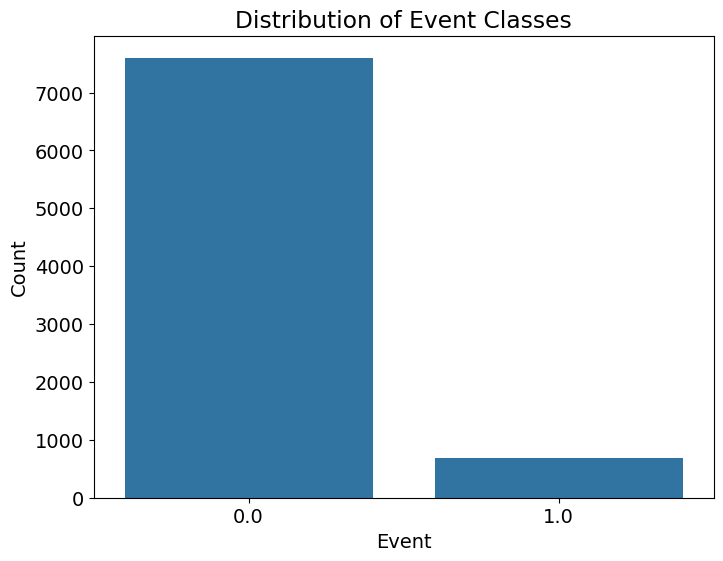

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and 'event' is the target column
plt.figure(figsize=(8, 6))
sns.countplot(x='event', data=df2)
plt.title('Distribution of Event Classes')
plt.xlabel('Event')
plt.ylabel('Count')
plt.show()

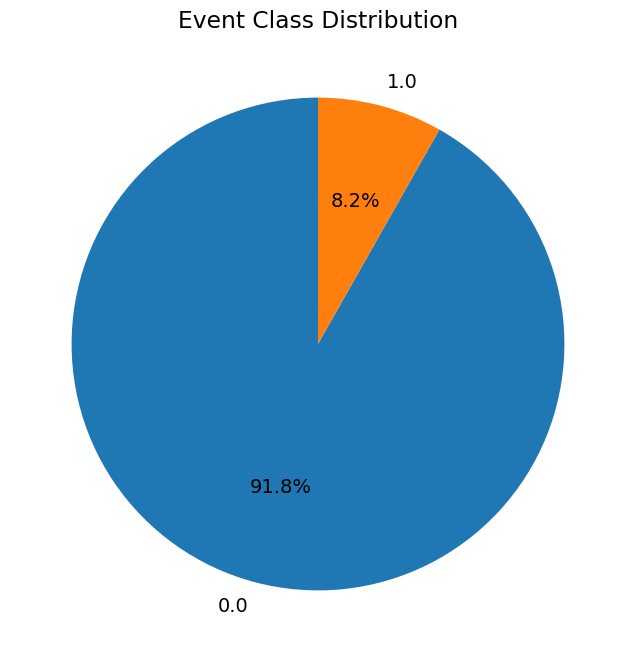

In [8]:
plt.figure(figsize=(8, 8))
df['event'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90)
plt.title('Event Class Distribution')
plt.ylabel('')  # Hide the y-label for clarity
plt.show()

In [9]:
df2.shape

(8280, 21)

# Training a Decision Tree

In [23]:
# Train test split
X = df2.drop('event', axis=1)
y = df2['event']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Classifier Tree
dec_tree = DecisionTreeClassifier(random_state=123, max_depth=4)
dec_tree.fit(X_train, y_train)

# Predicting
y_pred = dec_tree.predict(X_test)

# Evaluating
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.2f}")

print("Classification Report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:\n", cm)

Accuracy: 0.91
Classification Report:
               precision    recall  f1-score   support

         0.0       0.91      1.00      0.96      1515
         1.0       0.00      0.00      0.00       141

    accuracy                           0.91      1656
   macro avg       0.46      0.50      0.48      1656
weighted avg       0.84      0.91      0.87      1656

Confusion Matrix:
 [[1514    1]
 [ 141    0]]


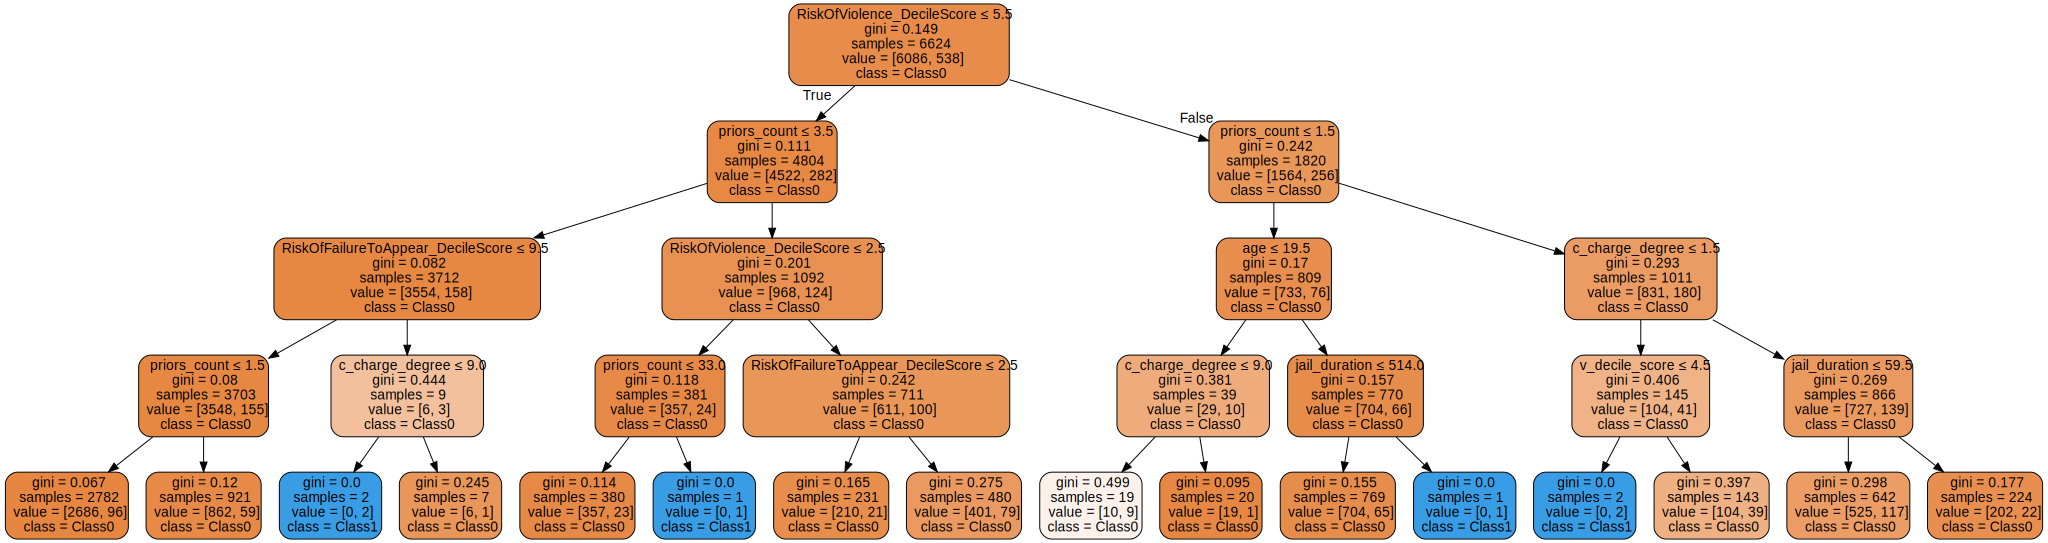

In [11]:
# Tree visualisation
dot_data = tree.export_graphviz(
    dec_tree,
    out_file=None,  # if we set this to None, we get the output as a string
    feature_names=X_train.columns,
    class_names=['Class0', 'Class1'],
    filled=True,
    rounded=True,
    special_characters=True
)

# Convert to a graphviz object
graphviz.Source(dot_data, format='png')

\# Because of the imbalance we are not able to train a good decision tree. So we need to do something to address this imbalance.

## Trying to balance the classes

In [12]:
## Using class_weight='balanced'
# Train test split
X = df2.drop('event', axis=1)
y = df2['event']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Train classifier with class_weight parameter as an alternative method
dec_tree_wb = DecisionTreeClassifier(class_weight='balanced', random_state=123, max_depth=4)
dec_tree_wb.fit(X_train, y_train)

# Predicting
y_pred = dec_tree_wb.predict(X_test)

# Evaluating
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.2f}")
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.64
Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      0.64      0.77      1515
         1.0       0.14      0.62      0.23       141

    accuracy                           0.64      1656
   macro avg       0.54      0.63      0.50      1656
weighted avg       0.88      0.64      0.72      1656

Confusion Matrix:
 [[975 540]
 [ 53  88]]


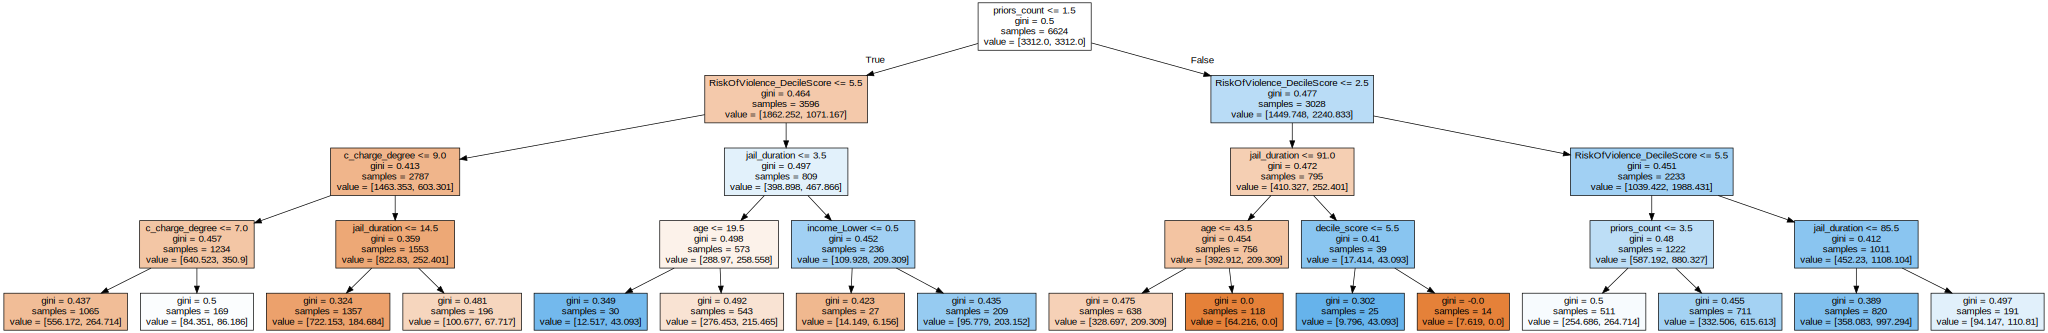

In [13]:
# weight balanced Tree visualisation
dot_data = tree.export_graphviz(dec_tree_wb, out_file=None, feature_names=X_test.columns, filled=True)
graphviz.Source(dot_data, format="png")

In [27]:
from imblearn.under_sampling import RandomUnderSampler

# Train test split
X = df2.drop('event', axis=1)
y = df2['event']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# Undersample the majority class using RandomUnderSampler
rus = RandomUnderSampler(random_state=123)
X_train_res, y_train_res = rus.fit_resample(X_train, y_train)

# Train classifier (no class_weight needed as we're balancing the classes via undersampling)
dec_tree_und = DecisionTreeClassifier(random_state=123, max_depth=4)
dec_tree_und.fit(X_train_res, y_train_res)

# Predicting
y_pred = dec_tree_und.predict(X_test)

# Evaluating
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.2f}")
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.64
Classification Report:
               precision    recall  f1-score   support

         0.0       0.94      0.65      0.77      1515
         1.0       0.13      0.58      0.22       141

    accuracy                           0.64      1656
   macro avg       0.54      0.62      0.49      1656
weighted avg       0.87      0.64      0.72      1656

Confusion Matrix:
 [[986 529]
 [ 59  82]]


\# Compared to the base case (compas algorithm results in the final-xai-group-project-story file), with this model we were able to increase recall for class 1 (with roughly the same precision). However, this comes at the cost of reducing recall for class 0. So two ideas come to mind:
1.In our user study with the judges, we should discuss this, and determine which combination of metrics is more desireable.
2.Eventhough we have made some progress, the predictions of the model is far from optimal. We need to know if there are other more relevant features we should include. (We can also try more complex but less explainable models to see if we can improve the results.)

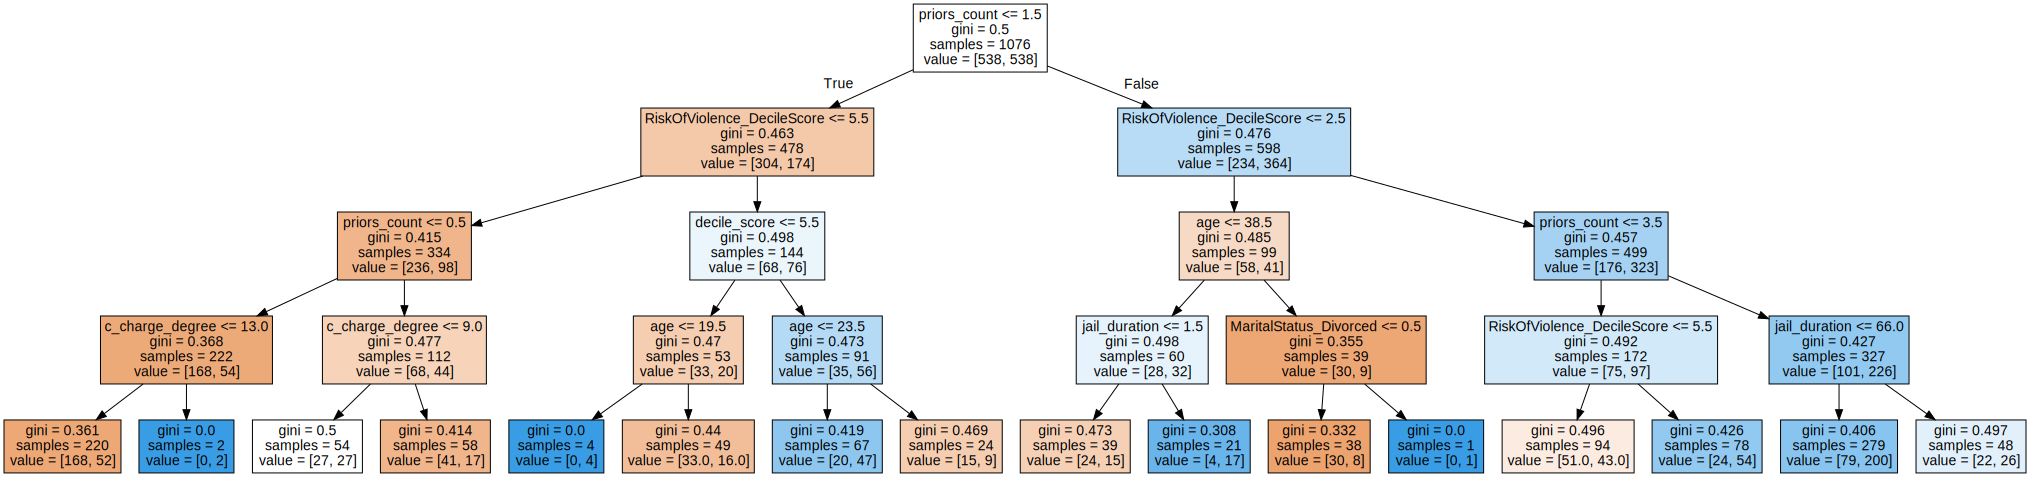

In [31]:
# under sampled Tree visualisation
dot_data = tree.export_graphviz(dec_tree_und, out_file=None, feature_names=X_test.columns, filled=True)
graph = graphviz.Source(dot_data, format="png")
output_path = graph.render(filename="decision_tree_und", cleanup=True)
graph

In [34]:
dot_data = tree.export_graphviz(
    dec_tree_und,
    out_file=None,
    feature_names=X_test.columns,
    filled=True,
    impurity=False
)

graph_attrs = 'graph [nodesep=0.1, ranksep=2.0, size="8,10!", ratio="compress"];'
dot_data = dot_data.replace("digraph Tree {", "digraph Tree {\n" + graph_attrs)

# Export as SVG (vector format)
graph = graphviz.Source(dot_data, format="svg")
output_path = graph.render(filename="decision_tree_und_custom_vector", cleanup=True)

print(f"Decision tree vector image exported to: {output_path}")


Decision tree vector image exported to: decision_tree_und_custom_vector.svg


In [35]:
dot_data = tree.export_graphviz(
    dec_tree_und,
    out_file=None,
    feature_names=X_test.columns,
    filled=True,
    impurity=False,
    max_depth=3  # Adjust this to remove the last level; set it one less than the full depth
)

# Adjust graph attributes to compress the image
graph_attrs = 'graph [nodesep=0.05, ranksep=1.5, size="8,10!", ratio="compress"];'
dot_data = dot_data.replace("digraph Tree {", "digraph Tree {\n" + graph_attrs)

# Export as SVG for high-quality vector output
graph = graphviz.Source(dot_data, format="svg")
output_path = graph.render(filename="decision_tree_und_custom_vector_truncated", cleanup=True)

print(f"Decision tree vector image exported to: {output_path}")


Decision tree vector image exported to: decision_tree_und_custom_vector_truncated.svg


In [37]:
import re
from sklearn import tree
import graphviz

# Export the decision tree to DOT format
dot_data = tree.export_graphviz(
    dec_tree_und,
    out_file=None,
    feature_names=X_test.columns,
    filled=True,
    impurity=False  # Remove impurity info
)

# Add custom graph attributes (adjusting spacing, size, etc.)
graph_attrs = 'graph [nodesep=0.05, ranksep=1.5, size="8,10!", ratio="compress"];'
dot_data = dot_data.replace("digraph Tree {", "digraph Tree {\n" + graph_attrs)

# Function to remove extra details from leaf nodes
def shorten_leaf_labels(dot_str):
    # This function will look for label attributes and, if the label text does not contain '<=',
    # assumes it's a leaf node and keeps only the first line.
    def repl(match):
        full_label = match.group(1)
        # If the label does not contain a decision condition, it's likely a leaf.
        if '<=' not in full_label:
            first_line = full_label.split('\\n')[0]
            return f'label="{first_line}"'
        # Otherwise, leave the label unchanged.
        return match.group(0)

    # Replace all label attributes accordingly.
    return re.sub(r'label="([^"]+)"', repl, dot_str)

# Apply the function to remove extra details from leaves
dot_data = shorten_leaf_labels(dot_data)

# Export as SVG (vector format) to keep high quality
graph = graphviz.Source(dot_data, format="svg")
output_path = graph.render(filename="decision_tree_und_custom_vector_truncated", cleanup=True)

print(f"Decision tree vector image exported to: {output_path}")


Decision tree vector image exported to: decision_tree_und_custom_vector_truncated.svg


# SHAP

In [16]:
import shap

class_index = -1
X_train_shap, X_test_shap = X_train_res.astype(float), X_test.astype(float)

explainer = shap.TreeExplainer(dec_tree_und, X_train_shap)

In [17]:
shap.initjs()
shap_values = explainer.shap_values(X_test_shap)
print(shap_values.shape)
shap.force_plot(explainer.expected_value[class_index], shap_values[:, :, class_index], X_test_shap)

(1656, 20, 2)


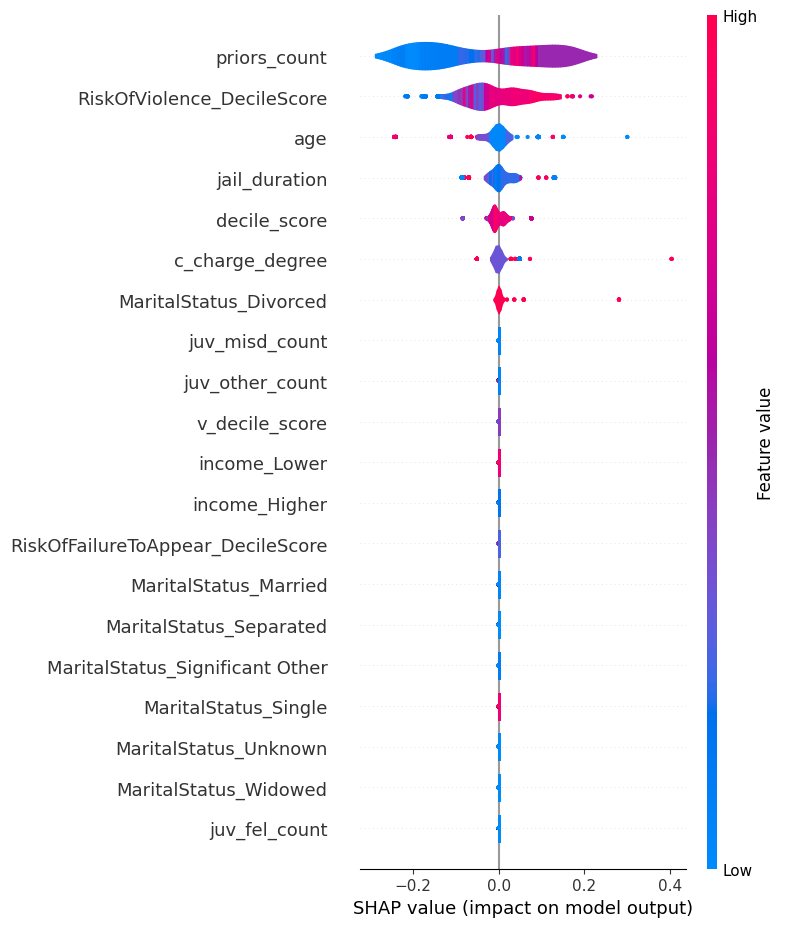

In [18]:
shap_values = explainer.shap_values(X_test_shap)
shap.summary_plot(shap_values[:, :, -1], X_test_shap, plot_type="violin", max_display=100)

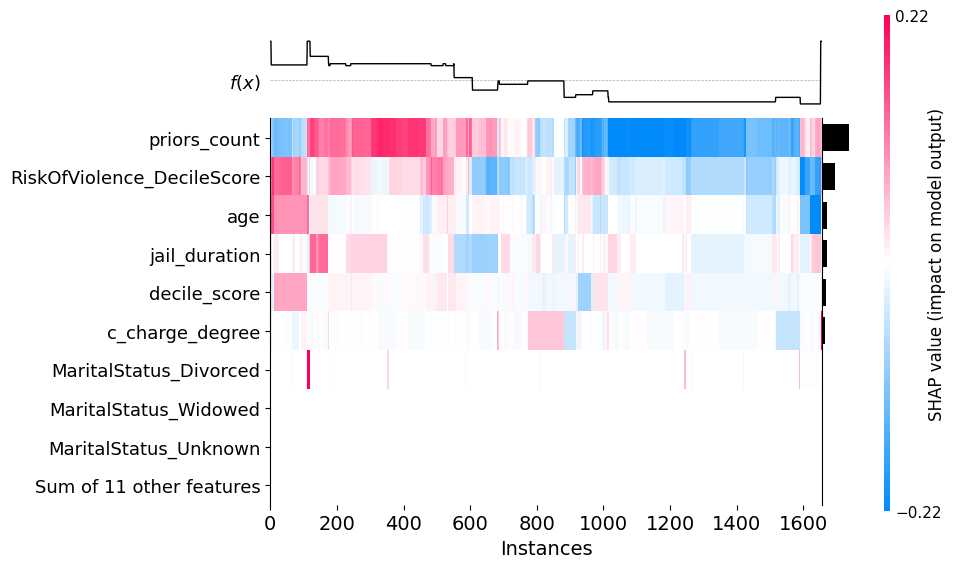

<Axes: xlabel='Instances'>

In [19]:
shap_values = explainer(X_test_shap)
shap.plots.heatmap(shap_values[:,:,class_index])

# PDP

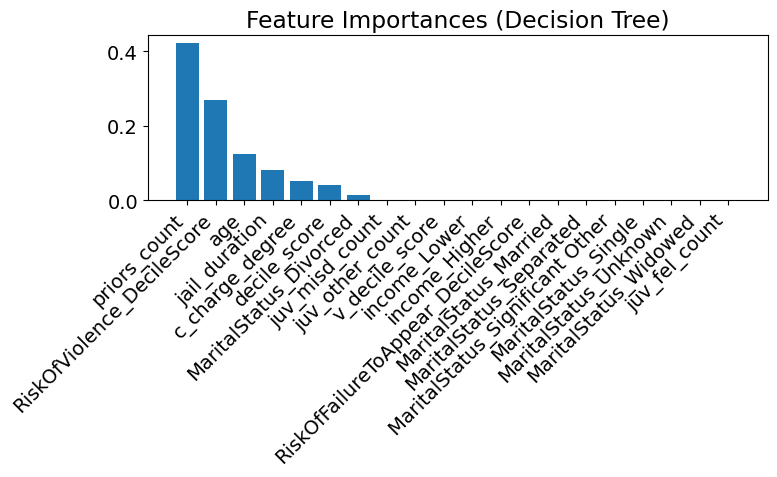

In [20]:
# Get feature importances
importances = dec_tree_und.feature_importances_
feature_names = X_train_res.columns

# Sort features by importance (descending)
indices = np.argsort(importances)[::-1]

# Plot
plt.figure(figsize=(8, 5))
plt.title("Feature Importances (Decision Tree)")
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45, ha='right')
plt.tight_layout()
plt.show()


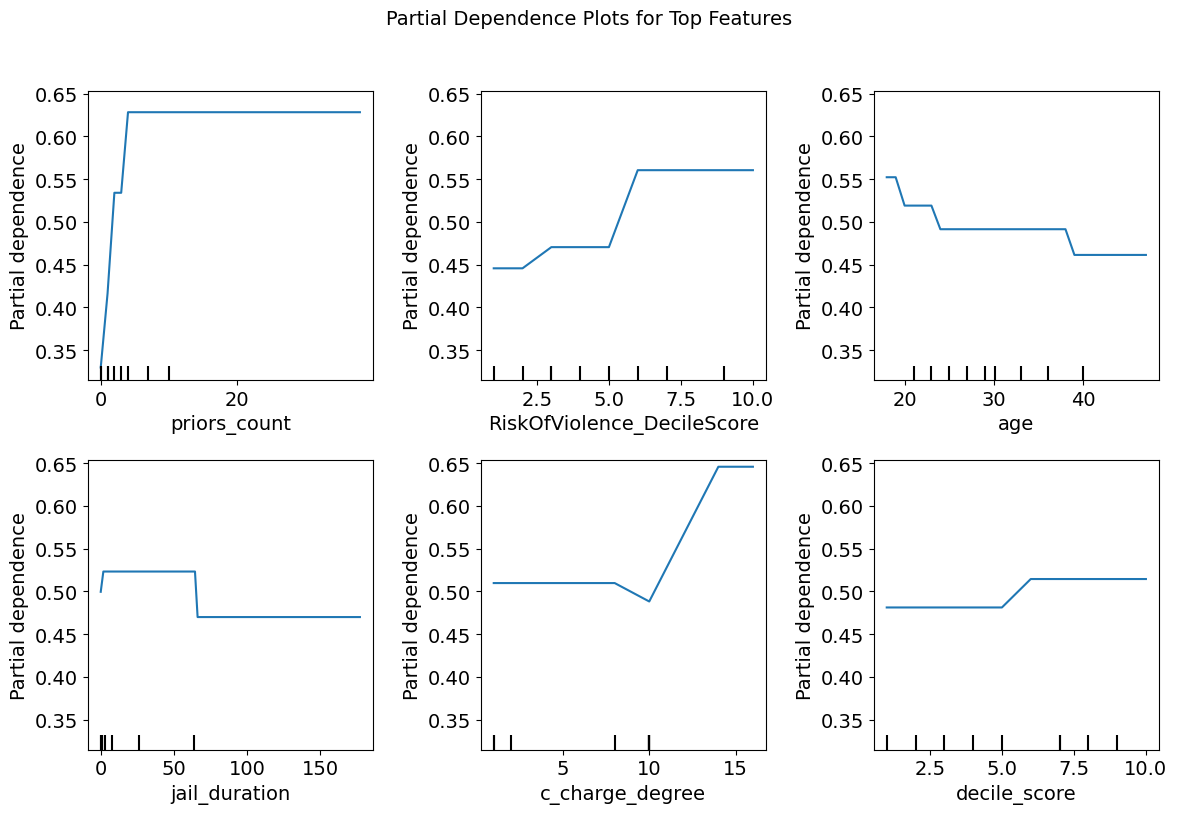

In [21]:
n_features = 6
features_to_plot = [feature_names[i] for i in indices[:n_features]]

# 3 columns
n_cols = 3
n_rows = int(np.ceil(n_features / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 4))
axes = axes.flatten()

PartialDependenceDisplay.from_estimator(
    dec_tree_und,
    X_train_res,
    features=features_to_plot,
    feature_names=feature_names,
    kind='average',
    ax=axes
)

plt.suptitle("Partial Dependence Plots for Top Features", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()


1/ Priors count dominates. From the bar chart, priors_count has by far the highest importance. In its PDP, you can see a big jump from near 0.35 probability to 0.60+ once someone goes from 0 to 1 or more priors. Essentially, any prior arrests/convictions drive the model’s predicted probability of re‐offense sharply upward.

2/ Risk of Violence Decile Score also matters. The PDP for RiskOfViolence_DecileScore shows probability rising from about 0.45 at lower scores to around 0.60 at the higher end. This tells you that, after priors, the COMPAS risk score is the second‐most influential factor.

3/ Age has a negative relationship. Its partial dependence plot slopes downward from about 0.60 at age ~20 to about 0.45 by age ~40. So younger people are predicted as higher risk, older people lower risk.

4/ Other factors—like jail duration, charge degree, etc.—play smaller roles but still shift predictions at certain values. For instance, the model predicts somewhat higher probability for more severe charges and for shorter jail stints (likely reflecting that short stints can coincide with more frequent offenses).

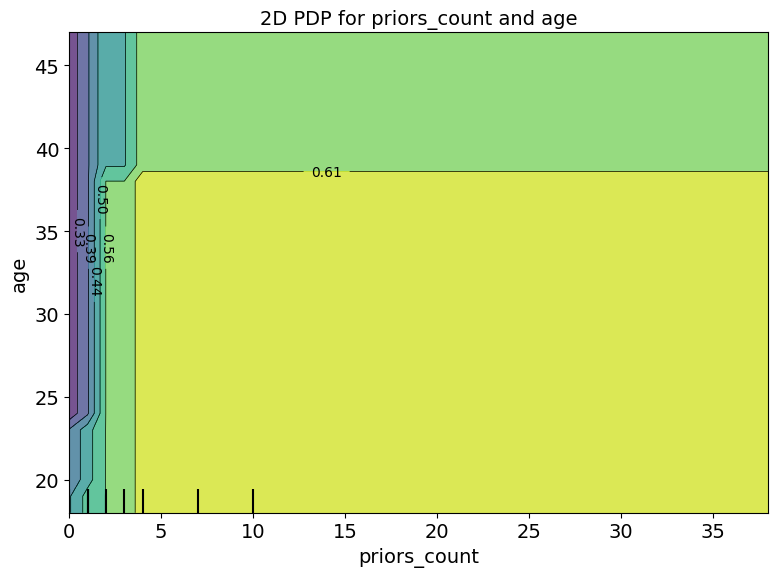

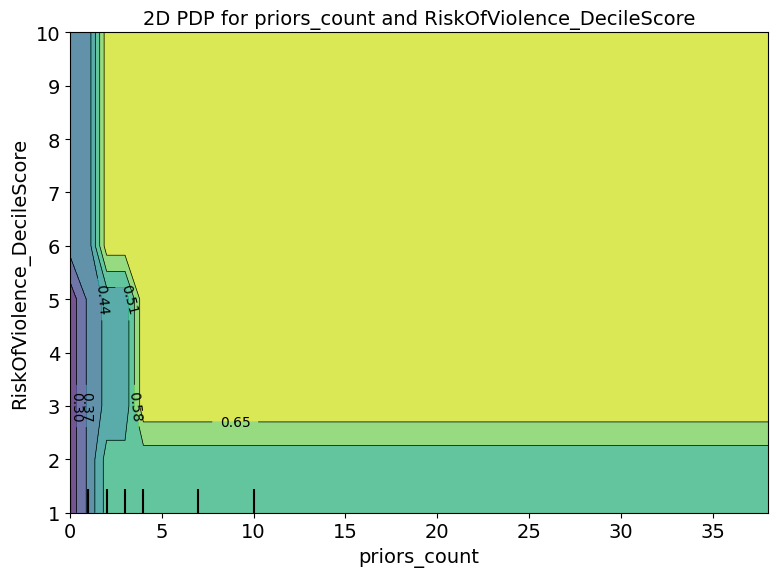

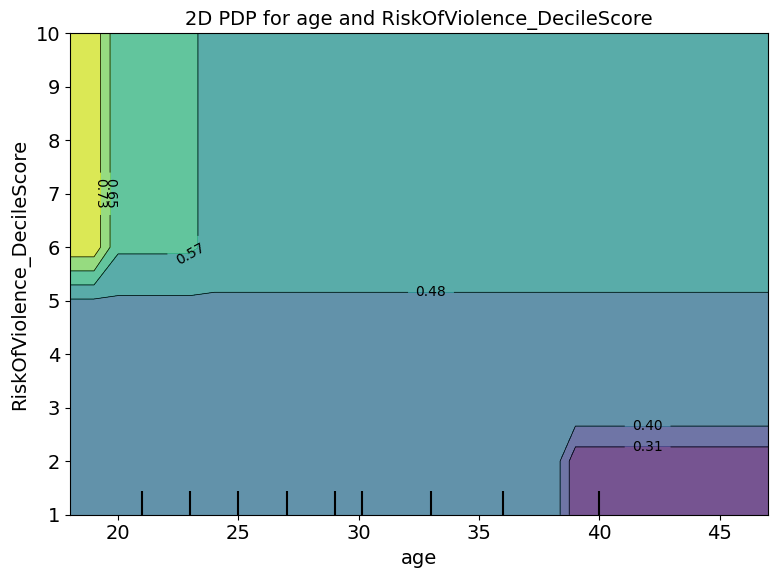

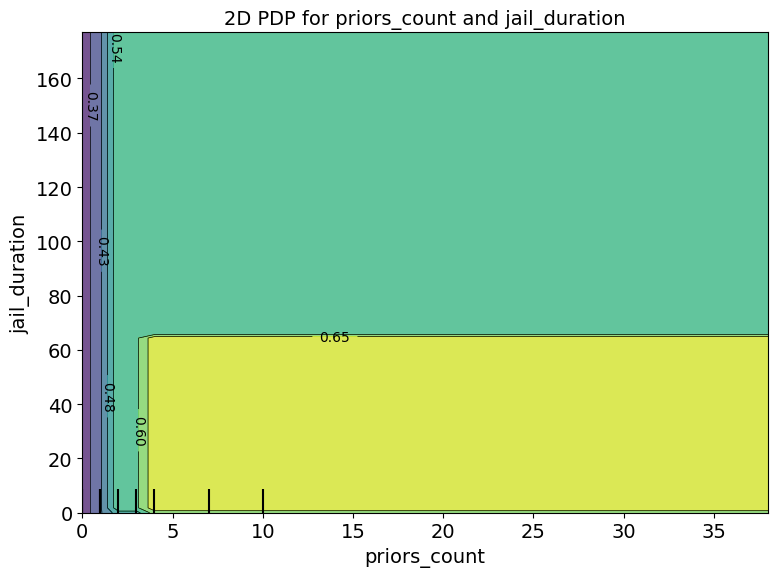

In [22]:
pairs = [
    ('priors_count', 'age'),
    ('priors_count', 'RiskOfViolence_DecileScore'),
    ('age', 'RiskOfViolence_DecileScore'),
    ('priors_count', 'jail_duration')
]

for pair in pairs:
    # Adjust the figsize (width, height in inches) as desired
    fig, ax = plt.subplots(figsize=(8, 6))
    PartialDependenceDisplay.from_estimator(
        dec_tree_und,
        X_train_res,
        features=[pair],
        feature_names=feature_names,
        kind='average',
        ax=ax
    )
    plt.title(f'2D PDP for {pair[0]} and {pair[1]}', fontsize=14)
    plt.tight_layout()
    plt.show()

1/ Priors Count vs. Age
The biggest change is between “priors_count = 0” (the far‐left column of the plot) and “priors_count >= 1.” Having any prior record vaults the PDP from the low‐ to mid‐30% range up to around 0.60+ probability.
Once you have nonzero priors, age further modulates the predictions: younger individuals (ages < ~40) stay near the 0.60 zone; older individuals (40+) move down toward the 0.44–0.50 range.

2/ Priors Count vs. Risk of Violence Decile
Again, zero priors keeps predicted probability fairly low, while a single prior or more pushes it up toward 0.60–0.65.
Within the group that has priors, a higher COMPAS “RiskOfViolence_DecileScore” nudges the prediction a bit higher still (the yellow region at ~0.65), while a lower decile score leaves it closer to ~0.55.

3/ Age vs. Risk of Violence Decile
For younger (teens/20s) and high decile scores (7–10), partial dependence is highest—0.85+ in some bins—suggesting a strong interaction between youth and the COMPAS violence risk.
At older ages or lower decile scores, the probability falls (e.g. around 0.40 at age 40+ and decile < 5).

4/Priors Count vs. Jail Duration
As before, the zero‐priors boundary is the largest jump (from about 0.35 to about 0.60).
Among those with priors, short jail durations are associated with higher predicted recidivism (~0.60–0.65), whereas long jail durations (e.g. >60 days) drop predictions to ~0.45.